In [3]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from matplotlib import rcParams
from ForceMapping import forceMapping as fm
from sklearn.preprocessing import MinMaxScaler
import optuna
from sklearn.metrics import mean_squared_error
np.set_printoptions(suppress=True)
from itertools import product
import pickle


#### Load the training data

In [98]:
data_for_train = np.load('data_for_train.npy')

In [99]:
# load the model
with open('RF_limb.pkl', 'rb') as f:
    esn_rf = pickle.load(f)

# predict the signals
predictions = esn_rf.predict(data_for_train[:,16:20])

In [100]:
period=140

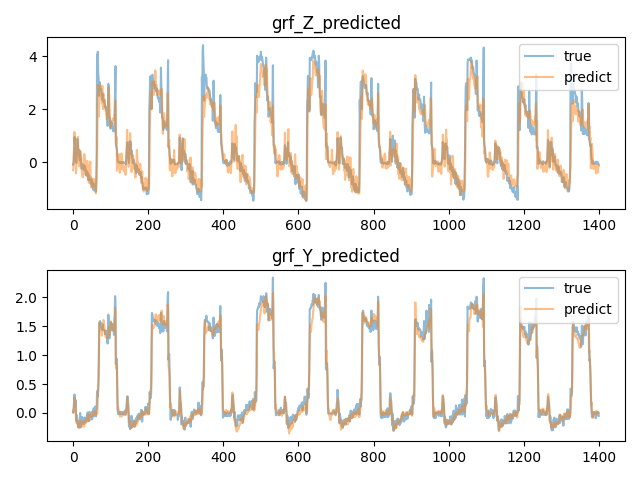

In [101]:
total_amount = 10
plt.close('all')
plt.subplot(2,1,1)
plt.plot(data_for_train[:period*total_amount,32], label='true', alpha=0.5)  # Adjust transparency
plt.plot(predictions[:period*total_amount,0], label='predict', alpha=0.5)  # Adjust transparency
plt.legend(loc='upper right')
plt.title('grf_Z_predicted')

plt.subplot(2,1,2)
plt.plot(data_for_train[:period*total_amount,33], label='true', alpha=0.5)  # Adjust transparency
plt.plot(predictions[:period*total_amount,1], label='predict', alpha=0.5)  # Adjust transparency
plt.legend(loc='upper right')
plt.title('grf_Y_predicted')
plt.tight_layout()

### Test for ESN prediction

In [18]:
predict_train_input.shape[0]/period

171.0

In [20]:
predict_train_input = predictions[:150*period,]
predict_train_output = data_for_train[:150*period,32:34]

predict_test_input = predictions[150*period:,]
predict_test_output = data_for_train[150*period:,32:34]

In [36]:
train_in = predict_train_input[:predict_train_input.shape[0]-60,:]
train_out = predict_train_output[60:,:]

In [40]:
esn_optimal = ESN(2, 100, 2, 0.85, 0.3, 0.6)
esn_optimal.fit(train_in, train_out)


In [41]:
grf_predicted = esn_optimal.predict(predict_test_input[:predict_test_input.shape[0]-60,:])

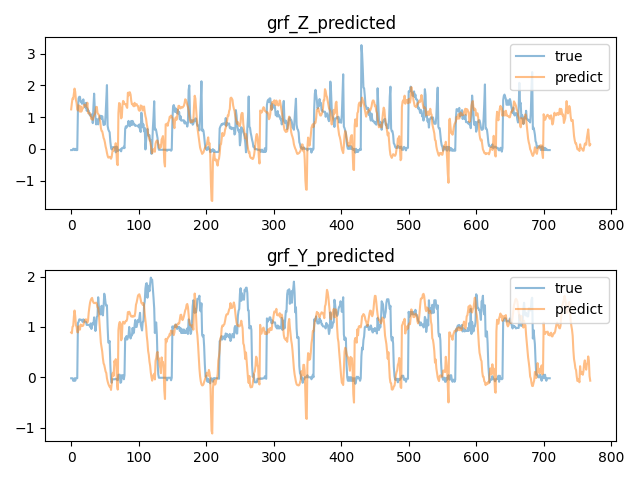

In [74]:
plt.close('all')
plt.subplot(2,1,1)
plt.plot(predict_test_output[60:,0], label='true', alpha=0.5)  # Adjust transparency
plt.plot(grf_predicted[:,0], label='predict', alpha=0.5)  # Adjust transparency
plt.legend(loc='upper right')
plt.title('grf_Z_predicted')

plt.subplot(2,1,2)
plt.plot(predict_test_output[60:,1], label='true', alpha=0.5)  # Adjust transparency
plt.plot(grf_predicted[:,1], label='predict', alpha=0.5)  # Adjust transparency
plt.legend(loc='upper right')
plt.title('grf_Y_predicted')
plt.tight_layout()

### Split the data by half (Rebuild the training set)

In [102]:
predict_train_input = predictions[:150*period,]
predict_train_output = data_for_train[:150*period,32:34]

predict_test_input = predictions[150*period:,]
predict_test_output = data_for_train[150*period:,32:34]

In [103]:
data_in,_ = split_by_half_period(predictions,period, 70,70)
_,data_out = split_by_half_period(data_for_train[:,32:34],period, 70,70)

In [104]:
predictions.shape

(23940, 2)

[]

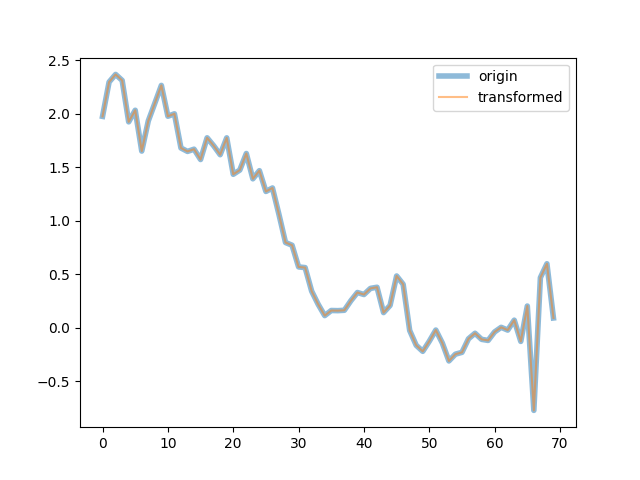

In [95]:
select_id = 5
plt.close('all')
plt.plot(predictions[period*select_id:period*select_id+70,0], label='origin', linewidth = 4, alpha=0.5) 
plt.plot(data_in[70*select_id:70*(select_id+1),0], label='transformed', alpha=0.5) 
plt.legend()
plt.plot()

[]

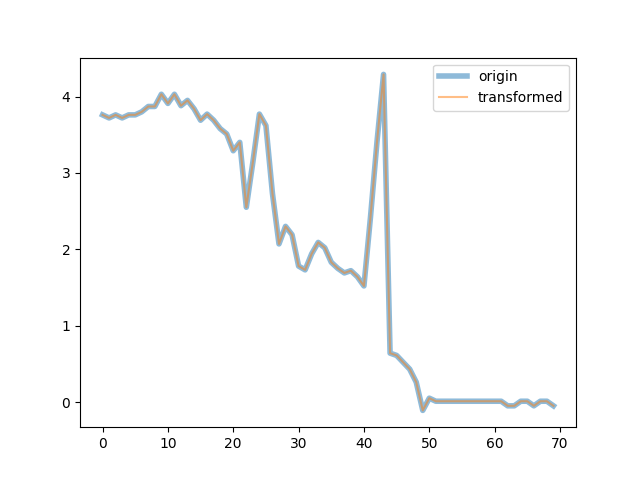

In [107]:
select_id = 26
plt.close('all')
plt.plot(data_for_train[period*select_id+70:period*select_id+140,32], label='origin', linewidth = 4, alpha=0.5) 
plt.plot(data_out[70*select_id:70*(select_id+1),0], label='transformed', alpha=0.5) 
plt.legend()
plt.plot()

In [122]:
data_in.shape

(11970, 2)

In [123]:
data_out.shape

(11970, 2)

In [110]:
np.save('data_in_for_predict.npy',data_in)

In [111]:
np.save('data_out_for_predict.npy',data_out)

#### standardize the data_in

In [116]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data_in = scaler.fit_transform(data_in[:,:].reshape(-1,1)).reshape(-1,2)

In [63]:
data_in.shape[0]/period

85.5

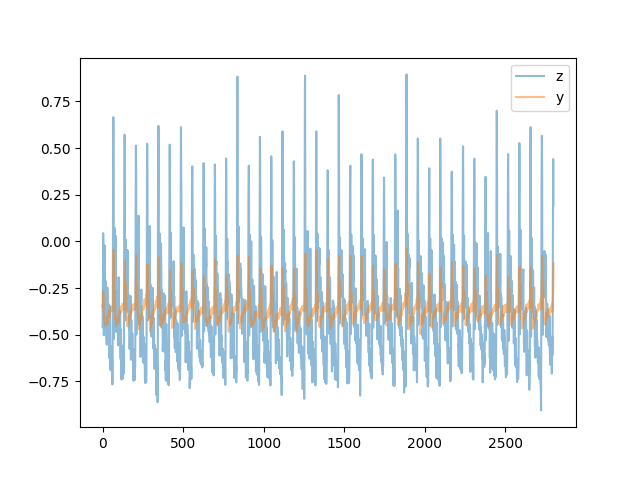

In [54]:
total_amount = 20
plt.close('all')
plt.plot(data_in[:period*total_amount,0], label='z', alpha=0.5) 
plt.plot(data_in[:period*total_amount,1], label='y', alpha=0.5) 
plt.legend()
plt.show()

In [124]:
predict_train_input = data_in[:70*period,:]
predict_train_output = data_out[:70*period,:]

predict_val_input = data_in[70*period:80*period,:]
predict_val_output = data_out[70*period:80*period,:]

predict_test_input = data_in[80*period:,:]
predict_test_output = data_out[80*period:,:]

In [126]:
predict_train_input.shape

(9800, 2)

In [143]:
# Your data
# train_inputs, train_targets, val_inputs, val_targets
# Make sure they're numpy arrays of appropriate shapes

# Your dataset
# train_inputs, train_targets, val_inputs, val_targets
# Ensure they are NumPy arrays

# Grid ranges
spectral_radius_range = [0.8, 0.85, 0.9, 0.95, 0.98]
sparsity_range = [0.1, 0.2, 0.3, 0.4, 0.5]
leak_rate_range = [0.1, 0.3, 0.6, 0.9]
reservoir_size_range = [60, 80, 100,120]

train_inputs = predict_train_input
train_targets = predict_train_output
val_inputs = predict_val_input
val_targets = predict_val_output
lowest_mse = float('inf')
best_params = None

# For progress tracking
combos = list(product(spectral_radius_range, sparsity_range, leak_rate_range, reservoir_size_range))
total_combos = len(combos)

for idx, (spectral_radius, sparsity, leak_rate, reservoir_size) in enumerate(combos, 1):
    esn = ESN(
        input_size=2,
        reservoir_size=reservoir_size,
        output_size=2,
        spectral_radius=spectral_radius,
        sparsity=sparsity,
        leak_rate=leak_rate,
        seed=42
    )

    esn.fit(train_inputs, train_targets)
    predictions = esn.predict(val_inputs)

    # Only evaluate on column 1
    mse = mean_squared_error(val_targets[:, 1], predictions[:, 1])

    if mse < lowest_mse:
        lowest_mse = mse
        best_params = (spectral_radius, sparsity, leak_rate, reservoir_size)

    print(f"[{idx}/{total_combos}] SR={spectral_radius:.2f}, Sparsity={sparsity:.2f}, Leak={leak_rate:.2f}, Size={reservoir_size}, MSE={mse:.4f}")

    if idx % 20 == 0:
        print(f"🔹 After {idx} iterations: Best MSE = {lowest_mse:.4f}, Params = {best_params}")

print("\nBest Parameters:")
print(f"Spectral Radius = {best_params[0]}")
print(f"Sparsity = {best_params[1]}")
print(f"Leak Rate = {best_params[2]}")
print(f"Reservoir Size = {best_params[3]}")
print(f"Validation MSE = {lowest_mse:.4f}")

[1/600] SR=0.80, Sparsity=0.10, Leak=0.10, Size=60, MSE=0.1166
[2/600] SR=0.80, Sparsity=0.10, Leak=0.10, Size=80, MSE=0.0896
[3/600] SR=0.80, Sparsity=0.10, Leak=0.10, Size=100, MSE=0.0851
[4/600] SR=0.80, Sparsity=0.10, Leak=0.10, Size=120, MSE=0.1057
[5/600] SR=0.80, Sparsity=0.10, Leak=0.10, Size=140, MSE=0.0746
[6/600] SR=0.80, Sparsity=0.10, Leak=0.10, Size=160, MSE=0.0634
[7/600] SR=0.80, Sparsity=0.10, Leak=0.30, Size=60, MSE=0.1618
[8/600] SR=0.80, Sparsity=0.10, Leak=0.30, Size=80, MSE=0.1424
[9/600] SR=0.80, Sparsity=0.10, Leak=0.30, Size=100, MSE=0.1033
[10/600] SR=0.80, Sparsity=0.10, Leak=0.30, Size=120, MSE=0.0735
[11/600] SR=0.80, Sparsity=0.10, Leak=0.30, Size=140, MSE=0.0787
[12/600] SR=0.80, Sparsity=0.10, Leak=0.30, Size=160, MSE=0.0934
[13/600] SR=0.80, Sparsity=0.10, Leak=0.60, Size=60, MSE=0.2104
[14/600] SR=0.80, Sparsity=0.10, Leak=0.60, Size=80, MSE=0.1978
[15/600] SR=0.80, Sparsity=0.10, Leak=0.60, Size=100, MSE=0.1933
[16/600] SR=0.80, Sparsity=0.10, Leak=0.

In [121]:
predict_train_input.shape

(21000, 2)

In [148]:
esn_optimal = ESN(2, 120, 2, 0.95, 0.3, 0.3)
esn_optimal.fit(predict_train_input, predict_train_output)

In [149]:
grf_predicted = esn_optimal.predict(predict_test_input)

In [146]:
predict_test_input.shape

(770, 2)

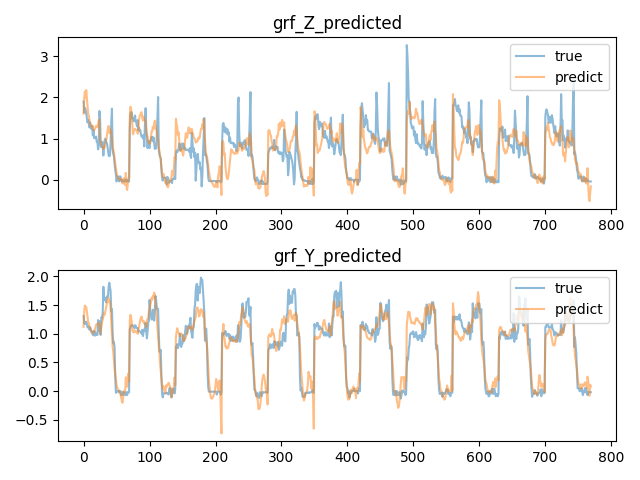

In [150]:
total_amount = 10
plt.close('all')
plt.subplot(2,1,1)
plt.plot(predict_test_output[:period*total_amount,0], label='true', alpha=0.5)  # Adjust transparency
plt.plot(grf_predicted[:period*total_amount,0], label='predict', alpha=0.5)  # Adjust transparency
plt.legend(loc='upper right')
plt.title('grf_Z_predicted')

plt.subplot(2,1,2)
plt.plot(predict_test_output[:period*total_amount,1], label='true', alpha=0.5)  # Adjust transparency
plt.plot(grf_predicted[:period*total_amount,1], label='predict', alpha=0.5)  # Adjust transparency
plt.legend(loc='upper right')
plt.title('grf_Y_predicted')
plt.tight_layout()

In [45]:
def split_by_half_period(data, period, front_half_period, back_half_period):
    n = data.shape[0] // period
    set_out1 = []
    set_out2 = []

    for i in range(n):
        start = i * period
        set_out1.append(data[start : start + front_half_period, :])
        set_out2.append(data[start + period - back_half_period : start + period, :])

    return np.vstack(set_out1), np.vstack(set_out2)

In [2]:
class ESN:
    def __init__(self, input_size, reservoir_size, output_size, 
                 spectral_radius=0.95, sparsity=0.1, leak_rate=0.9, seed=42):
        if seed is not None:
            np.random.seed(seed)

        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = output_size
        self.leak_rate = leak_rate

        # Input weights
        self.Win = np.random.uniform(-1, 1, (reservoir_size, input_size))

        # Reservoir weights
        W = np.random.rand(reservoir_size, reservoir_size) - 0.5
        mask = np.random.rand(*W.shape) < sparsity
        W *= mask  # sparsify
        eigvals = np.max(np.abs(np.linalg.eigvals(W)))
        self.Wres = W * (spectral_radius / eigvals)

        # Output weights (trained later)
        self.Wout = None

        self.state = np.zeros((reservoir_size,))

    def _update_state(self, u):
        pre_activation = np.dot(self.Win, u) + np.dot(self.Wres, self.state)
        new_state = np.tanh(pre_activation)
        self.state = (1 - self.leak_rate) * self.state + self.leak_rate * new_state
        return self.state

    def fit(self, inputs, targets, washout=50, ridge_lambda=1e-6):
        states = []
        for u in inputs:
            state = self._update_state(u)
            states.append(state)

        states = np.array(states)
        states_washed = states[washout:]
        targets_washed = targets[washout:]

        # Add bias term
        extended_states = np.hstack([states_washed, np.ones((states_washed.shape[0], 1))])
        
        # Ridge regression
        self.Wout = np.dot(np.linalg.pinv(extended_states), targets_washed)

    def predict(self, inputs):
        outputs = []
        for u in inputs:
            state = self._update_state(u)
            extended_state = np.concatenate([state, [1]])  # Add bias
            y = np.dot(extended_state, self.Wout)
            outputs.append(y)
        return np.array(outputs)